In [2]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# 定义 PyTorch 数据集
class HardDriveDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)  # 转为张量
        self.y = torch.tensor(y, dtype=torch.float32)  # 转为张量

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def normalize_smart_data(data, feature_indices):
    """
    对 SMART 数据进行归一化，每个特征独立归一化。
    :param data: ndarray，形状为 (num_records, max_days, features_per_day)
    :param feature_indices: list，每个特征的索引（时间戳不参与归一化）
    :return: 归一化后的数据
    """
    normalized_data = data.copy()
    for idx in feature_indices:
        feature_values = data[:, :, idx]
        min_val = np.min(feature_values)
        max_val = np.max(feature_values)
        if max_val > min_val:  # 避免除以零
            normalized_data[:, :, idx] = (feature_values - min_val) / (max_val - min_val)
        else:
            normalized_data[:, :, idx] = 0  # 如果特征是常量，则设为0
    return normalized_data

def prepare_data(data_list, max_days=10, features_per_day=3):
    X, y = [], []
    for record in data_list:
        if 'data' not in record or 'label' not in record:
            continue
        data = record['data']
        label = record['label']

        split_data = " ".join(map(str, data)).split('<SEP>')
        record_data = []

        for day in split_data:
            day_data = day.split()
            if len(day_data) > 1:
                # 跳过第一个时间戳字段，处理 SMART 数据
                smart_data = list(map(float, day_data[1:]))
                record_data.append(smart_data)
            else:
                record_data.append([0] * features_per_day)  # 填充空天

        # 填充到 max_days
        while len(record_data) < max_days:
            record_data.append([0] * features_per_day)
        record_data = record_data[:max_days]

        X.append(record_data)
        y.append(label)

    X = np.array(X)
    y = np.array(y)

    # 填充 NaN 为 0
    X = np.nan_to_num(X, nan=0)

    # 归一化 SMART 数据
    feature_indices = list(range(1, features_per_day))  # 跳过第一个时间戳字段
    X = normalize_smart_data(X, feature_indices)

    return X, y



In [13]:
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, mask):
        x = x * mask  # 忽略无效输入
        print(f"输入最大值: {torch.max(x)}, 最小值: {torch.min(x)}, 均值: {torch.mean(x)}")  # 检查输入
        _, (hidden, _) = self.lstm(x)
        print(f'hidden: \n{hidden}')
        out = self.fc(hidden[-1])
        return self.sigmoid(out)



In [9]:
import matplotlib.pyplot as plt




def train_and_evaluate_lstm(X, y, input_dim, hidden_dim=64, num_layers=2, batch_size=64, epochs=10, lr=0.001):
    # 划分数据集
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # 转换为 DataLoader
    train_dataset = HardDriveDataset(X_train, y_train)
    test_dataset = HardDriveDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # 初始化模型
    model = LSTMModel(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=1, num_layers=num_layers)
    criterion = nn.BCELoss()  # 或 nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # 记录损失
    train_losses = []
    
    # 训练模型
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for X_batch, y_batch in train_loader:
            # mask_batch = (X_batch != 0).float()  # 构建掩码
            optimizer.zero_grad()
            outputs = model(X_batch).squeeze()
            # print(f'X_batch: {X_batch}')
            print(f'output: {outputs}')
            print(f'y_batch: {y_batch}')
            break
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}")
    
    # 显示损失曲线
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, epochs + 1), train_losses, marker='o', label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.grid()
    plt.show()
    
    # 模型评估
    model.eval()
    y_pred, y_true, y_proba = [], [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch).squeeze()
            preds = (outputs > 0.5).float()
            y_pred.extend(preds.tolist())
            y_true.extend(y_batch.tolist())
            y_proba.extend(outputs.tolist())
    
    # 计算性能指标
    print("Classification Report:")
    print(classification_report(y_true, y_pred))
    
    auc = roc_auc_score(y_true, y_proba)
    print(f"AUC: {auc:.4f}")
    
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    print(f"TPR: {tpr:.4f}, FPR: {fpr:.4f}")
    
    return model


In [5]:
# 定义数据加载函数
import os
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
def load_data_from_folder(folder_path):
    all_data = []
    for file in tqdm(os.listdir(folder_path)):
        if file.endswith('.pkl'):
            file_path = os.path.join(folder_path, file)
            with open(file_path, 'rb') as f:
                data = pickle.load(f)
                all_data.extend(data)  # 每个文件有 10000 条记录，合并到一起
    return all_data


In [6]:
def main(data_folder):
    # 加载数据
    data = load_data_from_folder(data_folder)
    print(f"Total records loaded: {len(data)}")
    
    # 数据预处理
    max_days = 10
    features_per_day = 3  # 根据 SMART 数据的数量调整
    X, y = prepare_data(data, max_days=max_days, features_per_day=features_per_day)
    print(f"Data shape: {X.shape}, Labels shape: {y.shape}")
    
    # 模型训练与评估
    input_dim = features_per_day
    model = train_and_evaluate_lstm(X, y, input_dim=input_dim)
    print("Model training and evaluation complete.")
    return model


100%|██████████| 3/3 [00:00<00:00,  8.98it/s]


Total records loaded: 30002
Data shape: (30002, 10, 12), Labels shape: (30002,)
输入最大值: 4294967296.0, 最小值: 0.0, 均值: 54858688.0
hidden: 
tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]],

        [[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]]], grad_fn=<StackBackward0>)
output: tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,

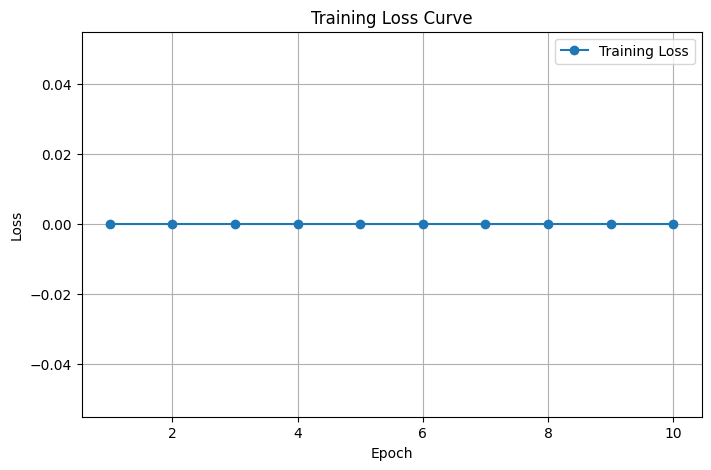

TypeError: forward() missing 1 required positional argument: 'mask'

In [14]:
data_folder = "/mnt/raid5/sum/card/storage/StreamDFP/dataset/train"  # 替换为实际数据路径
lstm_model = main(data_folder)